# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [1]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers

     |████████████████████████████████| 123 kB 8.1 MB/s 
     |████████████████████████████████| 90 kB 11.6 MB/s 
     |████████████████████████████████| 176 kB 59.2 MB/s 
     |████████████████████████████████| 131 kB 69.5 MB/s 
     |████████████████████████████████| 1.2 MB 60.5 MB/s 
     |████████████████████████████████| 895 kB 61.8 MB/s 
     |████████████████████████████████| 7.8 MB 58.9 MB/s 
     |████████████████████████████████| 79 kB 9.9 MB/s 
     |████████████████████████████████| 138 kB 64.8 MB/s 
     |████████████████████████████████| 127 kB 62.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [5]:
# from google.colab import drive
# drive.mount('/drive')

In [6]:
# !ls /drive/My\ Drive/Medium

In [7]:
# import sys
# sys.path.append('/drive/My Drive/Medium')

In [8]:
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json'

--2021-08-13 17:20:44--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   108MB/s    in 0.4s    

2021-08-13 17:20:46 (108 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]



In [9]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

--2021-08-13 17:20:46--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py’

utils_squad.py      100%[===================>]  40.56K  --.-KB/s    in 0.002s  

2021-08-13 17:20:46 (19.9 MB/s) - ‘utils_squad.py’ saved [41529/41529]

--2021-08-13 17:20:46--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 2

In [10]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
input_file = '/content/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [13]:
len(examples)

130319

In [14]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [15]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [16]:
train_data = train_data.sample(frac=0.2).reset_index(drop=True)

In [17]:
len(train_data)

26064

In [18]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
4578,56cddec762d2951400fa692c,Where did the reporters say they saw cracks on...,"[Reporters, in, Chengdu, said, they, saw, crac...",in Chengdu,1,2,False
6754,56d519a82593cc1400307a6b,What was reported in Chengdu?,"[Reporters, in, Chengdu, said, they, saw, crac...",cracks on walls,6,8,False
8459,56cddec762d2951400fa692d,Where were office towers evacuated?,"[Reporters, in, Chengdu, said, they, saw, crac...",Beijing,22,22,False


In [19]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [20]:
print_squad_sample(train_data)

CONTEXT: 
In his 2003 paper, "Human Genetic Diversity: Lewontin's Fallacy", A. W. F. Edwards argued
that rather than using a locus-by-locus analysis of variation to derive taxonomy, it is
possible to construct a human classification system based on characteristic genetic patterns, or clusters
inferred from multilocus genetic data. Geographically based human studies since have shown that such
genetic clusters can be derived from analyzing of a large number of loci which
can assort individuals sampled into groups analogous to traditional continental racial groups. Joanna Mountain
and Neil Risch cautioned that while genetic clusters may one day be shown to
correspond to phenotypic variations between groups, such assumptions were premature as the relationship between
genes and complex traits remains poorly understood. However, Risch denied such limitations render the
analysis useless: "Perhaps just using someone's actual birth year is not a very good
way of measuring age. Does that mean we

In [21]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
21063,56def8cbc65bf219000b3e5f,Who is the only person who can judge a Cardina...,"[Cardinals, have, in, canon, law, a, ""privileg...",the pope,21,22,False,132,81
18890,5a68f4c28476ee001a58a902,What was held for female system service profes...,"[IBM, was, among, the, first, corporations, to...",,-1,-1,True,166,62
15460,5727fe574b864d19001641a2,The English Dominican Order wanted to put what...,"[The, English, concentrated, on, the, spirit, ...",love,60,60,False,135,86
20335,5ad0b6aa645df0001a2d0128,"Because it is sponsored by the shareholders, w...","[The, Premier, League, is, a, corporation, in,...",,-1,-1,True,92,84
1663,5aceaf1632bba1001ae4b03b,What tends to imply a large number of founders...,"[Y, DNA, studies, tend, to, imply, a, small, n...",,-1,-1,True,252,68


In [22]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19674647022714%


In [23]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 580005.43B/s]


In [24]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 16

In [25]:
cached_features_file = '/content/cache_train'

In [26]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [27]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [28]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [35]:
train_sampler = RandomSampler(dataset,replacement=True, num_samples=int(0.2*len(dataset)))
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [36]:
len(train_sampler)

28852

In [37]:
import glob
checkpoints = sorted(glob.glob('checkpoint*-[0-9]*'))

In [38]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [39]:
if len(checkpoints) > 0:
  global_step = checkpoints[-1].split('-')[-1]
  ckpt_name = 'checkpoint-{}'.format(global_step)
  print("Loading model from checkpoint %s" % ckpt_name)
  model = BertForQuestionAnswering.from_pretrained(ckpt_name)
  train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
  train_loss_set = to_list(train_loss_set_ckpt)
  tr_loss = train_loss_set[-1]
else:
  global_step = 0
  train_loss_set = []
  tr_loss = 0.0
  model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [40]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0010,  0.0134, -0.0012,  ..., -0.0192,  0.0159, -0.0142],
        [ 0.0019,  0.0184,  0.0021,  ...,  0.0232, -0.0063, -0.0067]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0., 0.], device='cuda:0', requires_grad=True))


In [41]:
learning_rate = 5e-5
adam_epsilon=1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [42]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(iter(train_dataloader), desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = 'checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 16
  Total optimization steps = 1803


Iteration:   0%|          | 0/1803 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration:  55%|█████▌    | 1000/1803 [14:18<11:29,  1.16it/s]

Train loss: 1.76988218998909



Iteration:  56%|█████▌    | 1001/1803 [14:21<18:24,  1.38s/it]

Saving model checkpoint to checkpoint-1000



Epoch: 100%|██████████| 1/1 [25:50<00:00, 1550.62s/it]


In [ ]:
output_dir = 'checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [ ]:
train_loss_set_ckpt = torch.load('checkpoint-final/training_loss.pt')
train_loss_set = to_list(train_loss_set_ckpt)

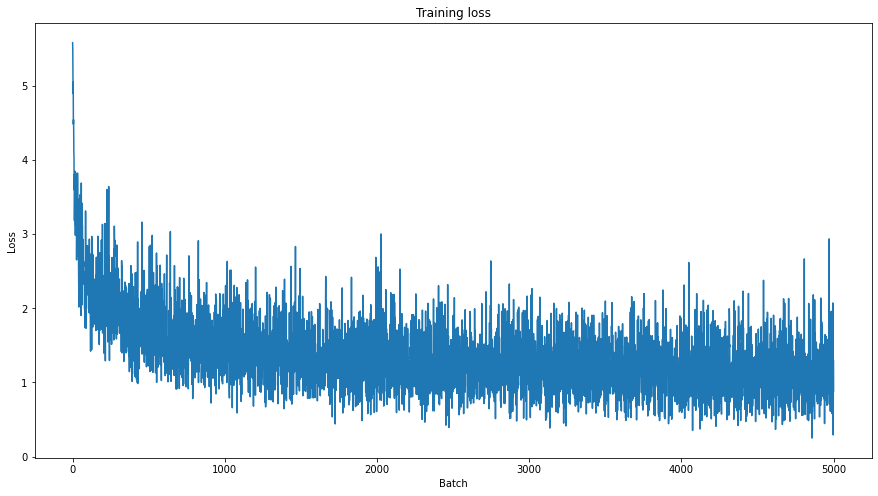

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [ ]:
!wget 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json'

--2021-08-13 16:48:33--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       100%[===================>]   4.17M  --.-KB/s    in 0.1s    

2021-08-13 16:48:33 (41.4 MB/s) - ‘dev-v2.0.json’ saved [4370528/4370528]



In [ ]:
input_file = 'dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = 'cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [ ]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = 'dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "predictions.json"
  output_nbest_file = "nbest_predictions.json"
  output_null_log_odds_file = "null_odds.json"
  output_dir = "predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)



Evaluating:   0%|          | 0/850 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 16




Evaluating:   0%|          | 0/850 [00:16<?, ?it/s]

Evaluating:   8%|▊         | 66/850 [00:16<03:14,  4.04it/s]

Evaluating:  10%|█         | 86/850 [00:21<03:09,  4.03it/s]

Evaluating:  12%|█▏        | 106/850 [00:26<03:05,  4.01it/s]

Evaluating:  15%|█▍        | 126/850 [00:31<03:02,  3.97it/s]

Evaluating:  17%|█▋        | 146/850 [00:36<02:57,  3.96it/s]

Evaluating:  20%|█▉        | 166/850 [00:41<02:53,  3.94it/s]

Evaluating:  22%|██▏       | 186/850 [00:46<02:49,  3.92it/s]

Evaluating:  24%|██▍       | 206/850 [00:52<02:45,  3.89it/s]

Evaluating:  26%|██▋       | 225/850 [00:57<02:41,  3.86it/s]

Evaluating:  29%|██▊       | 244/850 [01:02<02:38,  3.83it/s]

Evaluating:  31%|███       | 263/850 [01:07<02:34,  3.80it/s]

Evaluating:  33%|███▎      | 282/850 [01:12<02:30,  3.77it/s]

Evaluating:  35%|███▌      | 301/850 [01:17<02:26,  3.74it/s]

Evaluating:  38%|███▊      | 320/850 [01:22<02:22,  3.72it/s]

Evaluating:  40%|███▉      | 339/850 [01:27<02:18,  3.69it/s]

Ev

{
  "exact": 67.32081192621915,
  "f1": 70.37708152200675,
  "total": 11873,
  "HasAns_exact": 61.74089068825911,
  "HasAns_f1": 67.86219448562471,
  "HasAns_total": 5928,
  "NoAns_exact": 72.8847771236333,
  "NoAns_f1": 72.8847771236333,
  "NoAns_total": 5945,
  "best_exact": 68.12936915691064,
  "best_exact_thresh": -1.1092860698699951,
  "best_f1": 70.79088205902566,
  "best_f1_thresh": -1.1092860698699951
}


In [ ]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 67.32081192621915}, {'f1': 70.37708152200675}, {'total': 11873}, {'HasAns_exact': 61.74089068825911}, {'HasAns_f1': 67.86219448562471}, {'HasAns_total': 5928}, {'NoAns_exact': 72.8847771236333}, {'NoAns_f1': 72.8847771236333}, {'NoAns_total': 5945}, {'best_exact': 68.12936915691064}, {'best_exact_thresh': -1.1092860698699951}, {'best_f1': 70.79088205902566}, {'best_f1_thresh': -1.1092860698699951}]


**Evaluate on any text**

In [ ]:
with open('predictions.json') as f:
    best_predictions = json.load(f)

In [ ]:
import random

for example in random.sample(val_examples, 40):
    qas_id = example.qas_id
    question_text = example.question_text
    answer_text = best_predictions[qas_id]

    print(f'question       >> {question_text}')
    print(f'model\'s answer >> {answer_text}')

    print()

question       >> What does rebellion require in Christian Bay's encyclopedia?
model's answer >> 

question       >> The immune systems of bacteria have enzymes that protect against infection by what kind of cells?
model's answer >> unicellular

question       >> Where does the cold water mix with Lake Constance?
model's answer >> 

question       >> What can be viewed as a limited collection of instances together with a solution for every instance?
model's answer >> 

question       >> Where is the lowest point of Warsaw located?
model's answer >> 75.6 metres (248.0 ft) (at the right bank of the Vistula, by the eastern border of Warsaw

question       >> When was the Black Forest discovered?
model's answer >> 

question       >> In what year did the House of Guise gain influence?
model's answer >> 

question       >> What was abnormal British defense?
model's answer >> 

question       >> X.25 uses what type network type 
model's answer >> 

question       >> What river runs alongside